---
layout: notes
chapter: 4
chapter-title: Training Models
permalink: /ml-book/chapter4/notes.html
---

## Training Models
This chapter is all about what's under the hood of models. Understanding this will help us:
* Pick the appropriate model
* Use the right training algorithm
* Adjust hyperparameters
* Help with debugging and error analysis
* Help with understanding neural networks when we get to them

### Training a Linear Regression model
* Using a direct "closed-form" equation that computer the model parameters based on the best fit of the model to the data
* Using an iterative optimization approach such as Gradient Descent (GD) which finds parameters by tweaking parameters and minimizing the cost function

### Other Regression Models
* We'll look at Polynomial Regression which is more complex model, but also prone to overfitting
* We'll look at Logistic Regression and Softmax Regression

## Linear Regression

$$ \hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n $$

where:
* $\hat{y}$ is the predicted value
* $n$ is the number of features
* $x_i$ is the $i^{th}$ feature value
* $\theta_j$ is the $j^{th}$ model parameter ($\theta_0$ is the bias term and other $\theta_j$ terms are the feature weights)

#### Vectorized Form

$$ \hat{y} = h_{\theta}(\textbf{x}) = \theta^T \cdot \textbf{x} $$

Note here that $ x_0 = 1 $ to support the bias term $ \theta_0 $.

RMSE for Linear Regression:

$$ \text{MSE}(\textbf{X}, h_{\theta}) = \frac{1}{m} \sum_{i=1}^{m} (\theta^T \cdot \textbf{x}^{(i)} - y^{(i)})^2 $$

The summation is over all the samples in the data set. So i = 1 is the first sample of the dataset, i = 2 the second and so on, up to m.

### The Normal Equation
The normal equation solves this system of equations.


$$ \hat{\theta} = (\textbf{X}^T \cdot \textbf{X})^{-1} \cdot \textbf{X}^T \cdot \textbf{y} $$

Testing this out:

(0.0, 15.0)

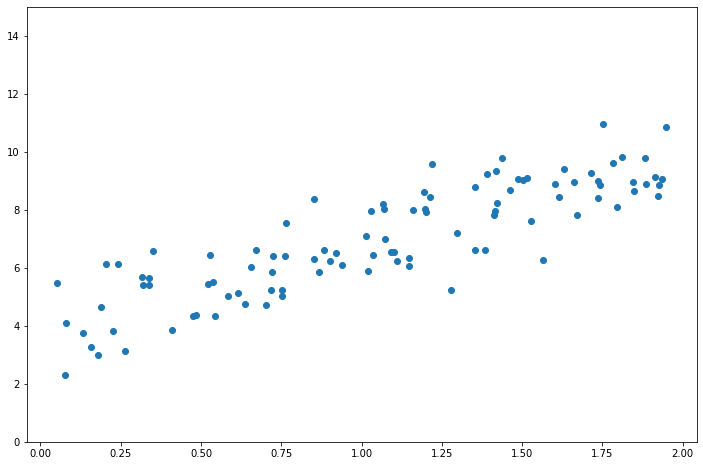

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12, 8)

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)
plt.scatter(X, y)
plt.ylim(0, 15)

[3.82007879 2.98907987]


(0.0, 15.0)

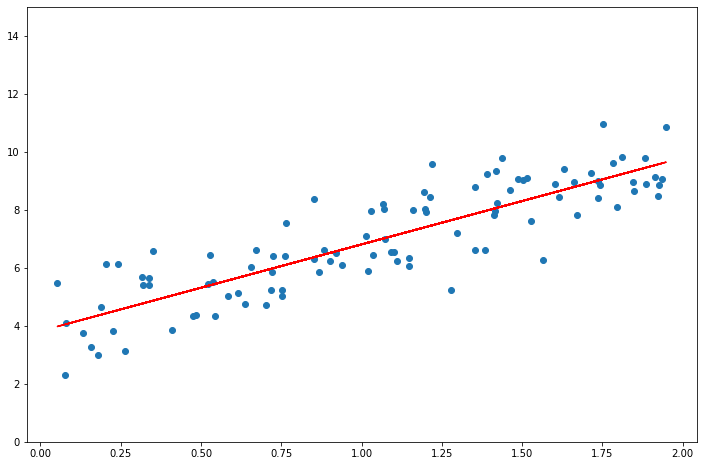

In [2]:
_X = np.hstack((np.ones((len(X), 1)), X))
t = np.linalg.inv(_X.T @ _X) @ _X.T @ y
print(t.flatten())
t = list(t.flatten())[::-1]
f = np.poly1d(t)
plt.scatter(X, y)
plt.plot(X, f(X), "r")
plt.ylim(0, 15)

{'fit_intercept': True, 'normalize': 'deprecated', 'copy_X': True, 'n_jobs': None, 'positive': False, 'n_features_in_': 1, 'coef_': array([[2.98907987]]), '_residues': array([92.71635422]), 'rank_': 1, 'singular_': array([5.49362575]), 'intercept_': array([3.82007879])}


(0.0, 15.0)

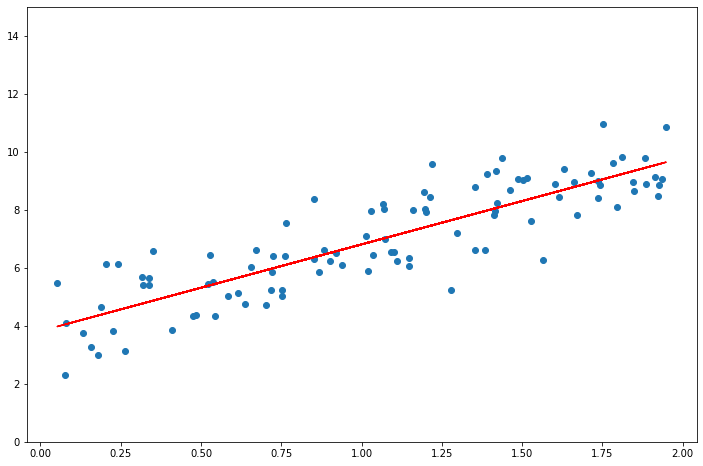

In [3]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.__dict__)
f = np.poly1d([lin_reg.coef_[0][0], lin_reg.intercept_[0]])
plt.scatter(X, y)
plt.plot(X, f(X), "r")
plt.ylim(0, 15)

### Computational Complexity
The computational complexity of the normal equation is $O(n^3)$ with respect to the number of features. Get's very slow with a large number of features (e.g. 100,000). However, it is $O(m)$ with respect to the number of samples. Once trained, predictions will be linear.

## Gradient Descent
Gradient descent will help handle cases when there are a large number of features or too many training instances to fit into memory. Gradient descent is a generic optimization algorithm capable of finding optimal solutions to a wide a range of problems. Tweak parameters iteratively in order to minimize a cost function. 

* The _learning rate_ hyperparameter dictates how quickly the algorithm will converge (it will need to go through more iterations if the learning rate is small). If it's too large you could be jumping across the solution.
* One of the pitfalls is that for non-convex cost functions the algorithm might converge to a local minimum instead of the global minimum.
* When using Gradient Descent you should ensure that all features are of the same scale, otherwise it will take much longer to converge.

### Batch Gradient Descent
We compute the partial derivatives w.r.t. each feature $\theta_j$ which results in (vectorized):

$$ \nabla_{\theta} \text{MSE}(\theta) = \frac{2}{m} \textbf{X}^T \cdot (\textbf{X} \cdot \theta - \textbf{y}) $$

Note here that $\textbf{X}$ is the _whole_ dataset. So this will be very slow on large datasets.

Once you know the direction uphill, just go in the opposite direction by taking a step:

$$ \theta_{t + 1} = \theta_t - \eta \nabla_{\theta} \text{MSE}(\theta) $$

#### Comparison of different learning rates

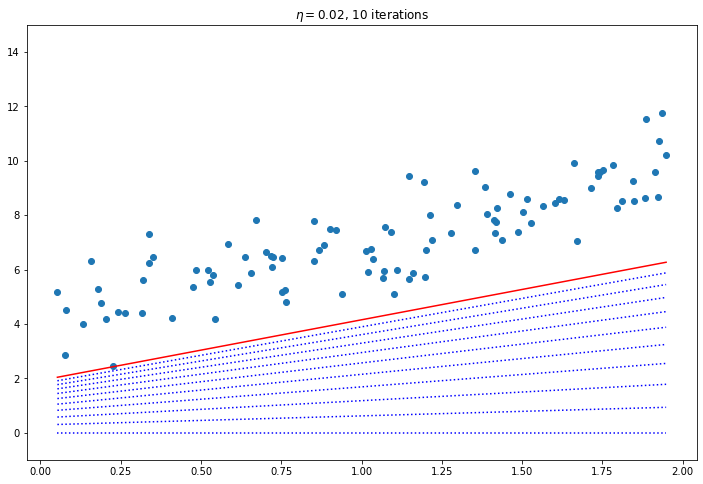

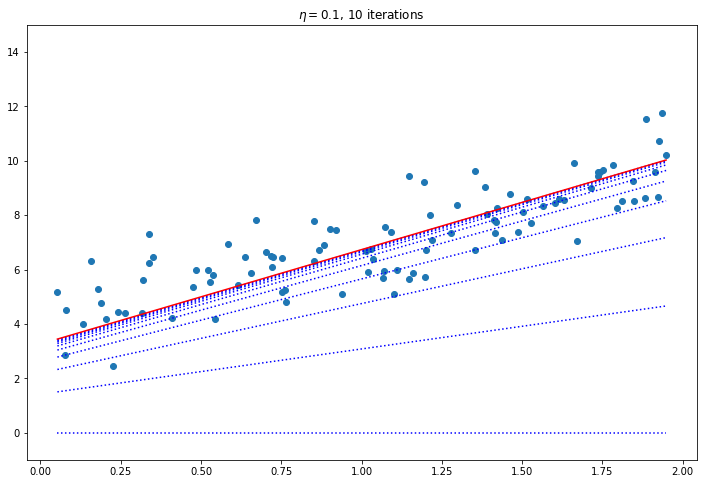

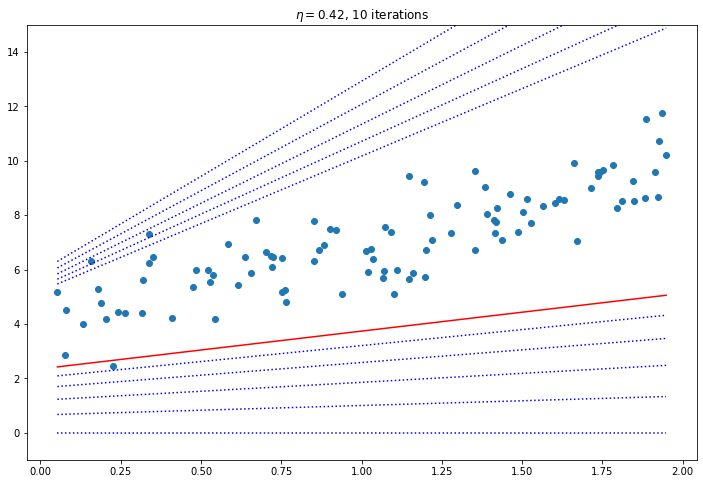

In [4]:
from IPython.display import display, Markdown

display(Markdown("#### Comparison of different learning rates"))
m = len(y)
X = np.sort(X, axis=0)
y = 4 + 3 * X + np.random.randn(100, 1)
_X = np.hstack((np.ones((len(X), 1)), X))
iters = 10
for eta in [0.02, 0.1, 0.42]:
    plt.figure()
    plt.ylim(-1, 15)
    theta = np.zeros((2, 1))
    for _ in range(iters):
        plt.plot(
            X[:: m - 1], np.poly1d(theta[:, 0][::-1])(X)[:: m - 1], c="b", ls="dotted"
        )
        grad_mse = 2 / m * _X.T @ (_X @ theta - y)
        theta = theta - eta * grad_mse
    plt.title(f"$\eta = {eta}$, {iters} iterations")
    plt.scatter(X, y)
    plt.plot(X[:: m - 1], np.poly1d(theta[:, 0][::-1])(X)[:: m - 1], "r")

#### Convergence Rate
How to pick the right learning rate? Perform a grid search, use a large number of iterations for GD, and use a tolerance (i.e. when the value changes very little stop). The convergence rate of GD with a fixed learning rate is $O(\frac{1}{iterations})$. So if you divide the stopping tolerance by 10 it will take 10 times as many iterations.

### Stochastic Gradient Descent
Stochastic Gradient Descent attempts to circumvent the pitfalls of batch gradient descent, by using a random sample  and computing the gradient step on those. This enables us to use much larger datasets which would be infeasible to compute the gradient of the entire batch. Obviously because the gradients are computed for each sample the variation is greater and convergence will never be perfectly optimal. If the cost function is irregular (contains local minima) then SGD will be better at jumping out of those local minima.

#### Simulated Annealing
Gradually reducing the learning rate so that the steps start out large and gradually get smaller and smaller, eventually settling at the local minimum is known as _simulated annealing_. The function that determines the learning rate at each iteration is call the _learning schedule_. 

Here's a gif from wikipedia where simulated annealing is used to find the maximum.

![Simulated Annealing](https://upload.wikimedia.org/wikipedia/commons/d/d5/Hill_Climbing_with_Simulated_Annealing.gif)

In [5]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.flatten())
print(sgd_reg.intercept_, sgd_reg.coef_)
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)
# Pretty close! Using much less computational power...

[4.01832491] [2.82868477]
[4.06367814] [[2.82792613]]


### Mini-batch Gradient Descent
Use a set of random samples, this is halfway between SGD and BGD. You can use `partial_fit` to implement this.

## Polynomial Regression
This is pretty much the same as Linear Regression, but obviously there are higher order terms.

## Learning Curves
* Overfitting/Underfitting
  * If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then your model is overfitting
  * If it performs poorly on both, then it is underfitting
  
* Learning Curves:

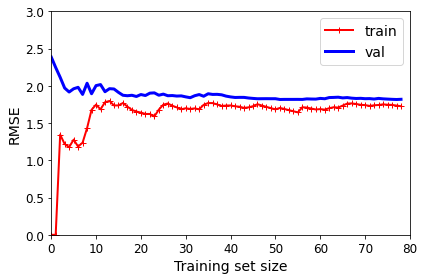

The hallmark of an overfitting model is that the model performs significantly better on training data than on validation data.

#### Bias/Variance Tradeoff
* Bias - Part of the error due to wrong assumptions, such as the data being quadratic, but using a linear model for it
* Variance - Part of the error which has excessive sensitivity to small variations in the training data. More degrees of freedom in your model --> greater variance --> overfitting. Counterpart of the bias.
* Irreducible Error - Noisiness of the data itself. Reduce by cleaning data (e.g. removing outliers).

## Regularized Linear Models
These are different ways to constrain the weights to prevent overfitting. We'll look at Ridge Regression, Lasso Regression, and Elastic Net.

### Ridge Regression
Regularization term:

$$ \alpha \Sigma_{i=1}^{n} \theta_i^2 $$

This forces the learning algorithm to fit the data, but also keep the weights as small as possible. The regularization term should only be added during training, not during evaluation/testing.

The hyperparameter $\alpha$ controls how much you want to regularize the model. If it's zero then it simplifies to linear regression.

Full cost function:

$$ J(\theta) = \text{MSE}(\theta) + \frac{\alpha}{2} \sum_{i=1}^{n} \theta_i^2 $$

It's important to scale the data (e.g. `StandardScaler`) before performing Ridge Regression.

[[0.         1.1349428  0.18296516 0.00912966 0.01570277 0.03751682
  0.05351644 0.07357822 0.10780682]]


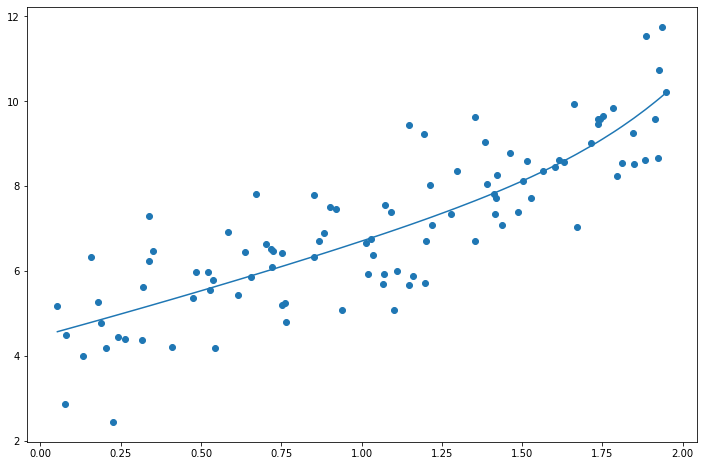

In [6]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

ridge_reg = Ridge(alpha=1, solver="cholesky")
X_poly = PolynomialFeatures(degree=8, include_bias=False).fit_transform(X)
stdscl = StandardScaler()
X_poly_scale = stdscl.fit_transform(X_poly)
X_poly_scale = np.hstack((np.ones((len(X_poly_scale), 1)), X_poly_scale))
ridge_reg.fit(X_poly_scale, y)
print(ridge_reg.coef_)
preds = ridge_reg.predict(X_poly_scale)
plt.plot(X, preds.flatten())
plt.scatter(X, y.flatten())

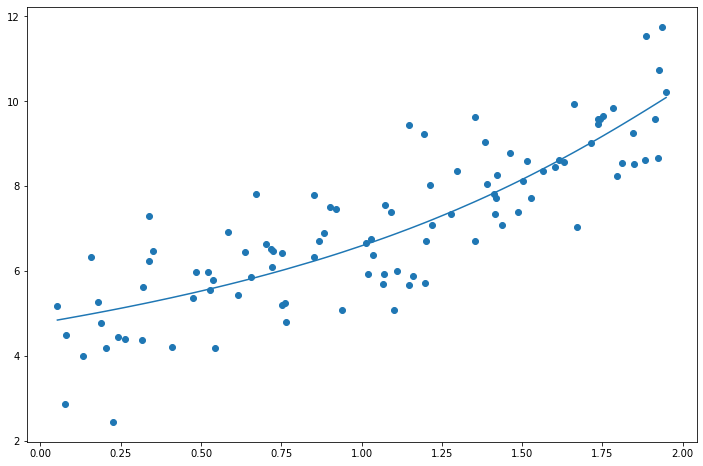

In [7]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

sgd_reg = SGDRegressor(alpha=0.001, penalty="l2")
X_poly = PolynomialFeatures(degree=8, include_bias=False).fit_transform(X)
stdscl = StandardScaler()
X_poly_scale = stdscl.fit_transform(X_poly)
X_poly_scale = np.hstack((np.ones((len(X_poly_scale), 1)), X_poly_scale))
sgd_reg.fit(X_poly_scale, y.flatten())
preds = sgd_reg.predict(X_poly_scale)
plt.plot(X, preds.flatten())
plt.scatter(X, y.flatten())

### Lasso Regression
Least Absolute Shrinkage and Selection Operator Regression uses the $l_1$ norm instead of the $l_2$ norm:

$$ J(\theta) = \text{MSE}(\theta) + \alpha \sum_{i=1}^{n} |\theta_i| $$

Important about Lasso Regularization is that it tends to completely eliminate the weights of the least important features.

[0.         1.18708147 0.         0.         0.01000136 0.31124557
 0.         0.         0.        ]


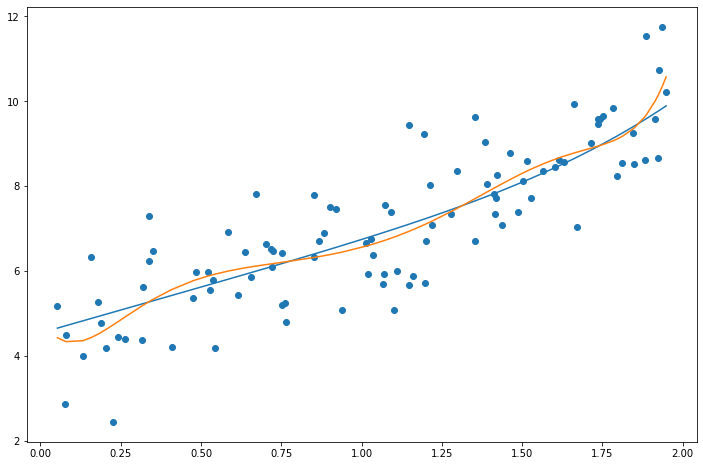

In [8]:
from sklearn.linear_model import Lasso, LinearRegression

lin_reg = LinearRegression()
lasso_reg = Lasso(alpha=0.1, max_iter=10**8)
X_poly = PolynomialFeatures(degree=8, include_bias=False).fit_transform(X)
stdscl = StandardScaler()
X_poly_scale = stdscl.fit_transform(X_poly)
X_poly_scale = np.hstack((np.ones((len(X_poly_scale), 1)), X_poly_scale))
lasso_reg.fit(X_poly_scale, y)
preds = lasso_reg.predict(X_poly_scale)
print(lasso_reg.coef_)  # Higher weights eliminated
lin_reg.fit(X_poly_scale, y)
lin_preds = lin_reg.predict(X_poly_scale)
plt.plot(X, preds.flatten())
plt.plot(X, lin_preds.flatten())
plt.scatter(X, y.flatten())

### Elastic Net
Elastic Net is a mix between Lasso and Ridge Regression. The mix ratio _r_ controls this balance. If _r_ = 0, then Elastic Net is equivalent to Ridge Regression, if _r_ = 1, then Elastic Net is equivalent to Lasso Regression:

$$ J(\theta) = \text{MSE}(\theta) + r \alpha \sum_{i=1}^{n} |\theta_i| + \frac{1 - r}{2} \alpha \sum_{i=1}^{n} \theta_i^2 $$

[0.         0.79239661 0.36310408 0.1797702  0.0958933  0.05120168
 0.02446791 0.0087832  0.00250297]


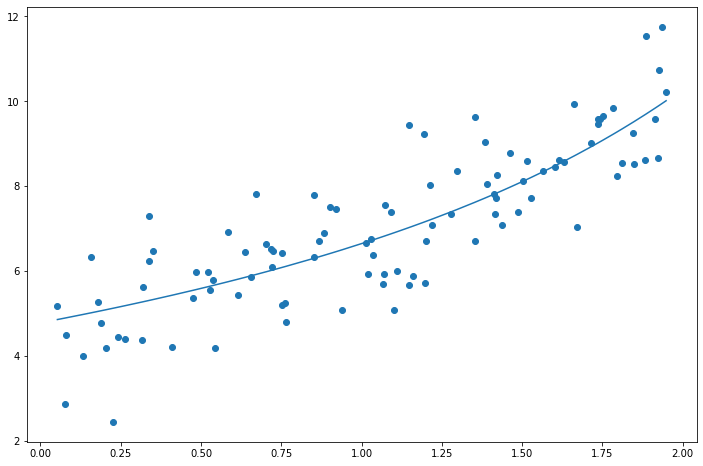

In [9]:
from sklearn.linear_model import ElasticNet

elas_reg = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10**8)
X_poly = PolynomialFeatures(degree=8, include_bias=False).fit_transform(X)
stdscl = StandardScaler()
X_poly_scale = stdscl.fit_transform(X_poly)
X_poly_scale = np.hstack((np.ones((len(X_poly_scale), 1)), X_poly_scale))
elas_reg.fit(X_poly_scale, y)
preds = elas_reg.predict(X_poly_scale)
print(elas_reg.coef_)  # Higher weights eliminated
plt.plot(X, preds.flatten())
plt.scatter(X, y.flatten())

#### *When should you use each of these?*

* Ridge is a good default
* Use Lasso or Elastic Net when you suspect that only a few features are actually important
* In general Elastic Net is preferred over straight Lasso because Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

### Early Stopping
Another regularization technique known as Early Stopping, is when you stop training as soon as the validation set reaches a minimum RMSE loss. Typically the validation RMSE loss will start to increase once the model starts to overfit.

## Logistic Regression
Logistic regression is commonly used to estimate the probability that an instance belongs to a particular class. If the probability is > 50% then it predicts that is the correct class, otherwise it predicts 0. Hence it is a binary classifier.

### Estimating Probabilities
Logistic regression model estimated probability:

$$ \hat{p} = h_{\theta}(\textbf{x}) = \sigma(\theta^T \cdot \textbf{x}) $$

where the logistic or _logit_ is a sigmoid function defines as:

$$ \sigma(t) = \frac{1}{1 + e^{-t}} $$

Text(0.5, 1.0, 'Sigmoid Function')

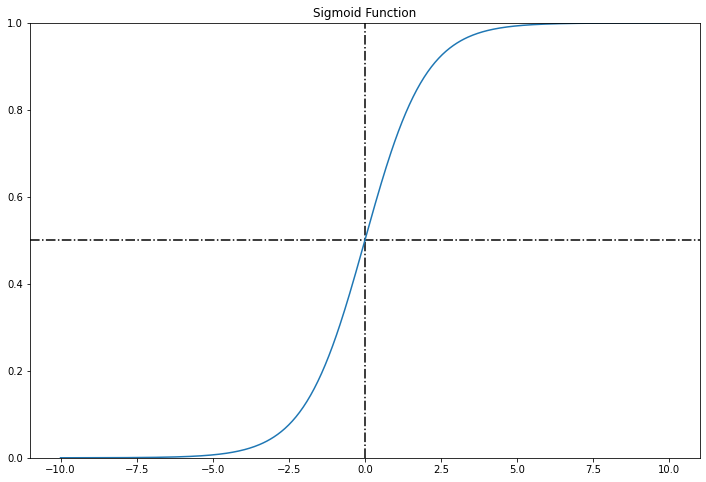

In [29]:
t = np.linspace(-10, 10, 500)
s = 1 / (1 + np.exp(-t))
plt.plot(t, s)
plt.ylim(*(0, 1))
plt.vlines(0, *plt.ylim(), ls="-.", color="k")
plt.xlim(*plt.xlim())
plt.hlines(0.5, *plt.xlim(), ls="-.", color="k")
plt.title("Sigmoid Function")

If $\hat{p} \ge 0.5$, then Logisitic Regression model predict 1, else it predicts 0. 

### Training and Cost Function
The cost function is:

$$
c (\theta) = 
  \left\{
    \begin{array}{l}
      - log (\hat{p}) \quad \quad \text{ if } y = 1\\
      - log (1-\hat{p}) \ \ \  \text{if } y = 0
    \end{array}
  \right.
$$

This makes sense. Now over the whole training set we would take the average. This is known as the log loss function:

$$ J(\theta) = - \frac{1}{m} \sum_{i=1}^m [ y_i log (\hat{p}_i) + (1 - y_i) log(1 - \hat{p}_i) ] $$

There's no closed form solution to this, but we can use BGD, SGD, or Mini-batch GD.

### Decision Boundaries
Use Iris dataset to explore decision boundaries. Build a classifier to detect the Iris-Virginica type based only on the petal width feature.

In [42]:
from sklearn import datasets

iris = datasets.load_iris()
print(iris["data"].shape)
print(iris["target"].shape)
X = iris["data"][:, 3:]
y = (iris["target"] == 2).astype(int)

(150, 4)
(150,)


In [44]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

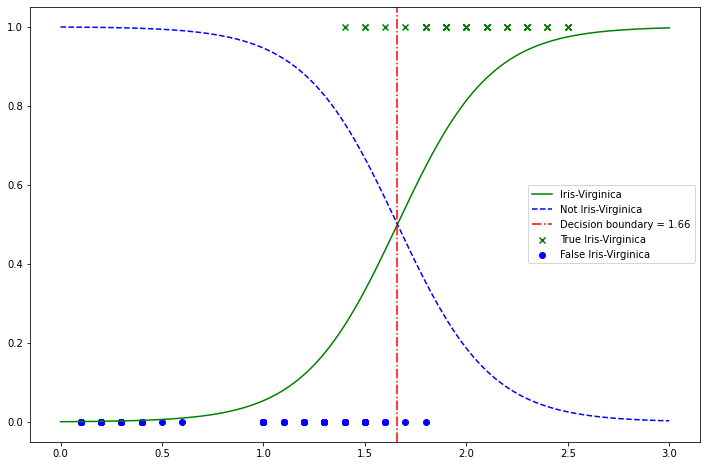

In [65]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new.flatten(), y_proba[:, 1], "g-", label="Iris-Virginica")
plt.plot(X_new.flatten(), y_proba[:, 0], "b--", label="Not Iris-Virginica")
plt.scatter(
    X[y == 1], np.ones(len(X[y == 1])), c="g", marker="x", label="True Iris-Virginica"
)
plt.scatter(X[y == 0], np.zeros(len(X[y == 0])), c="b", label="False Iris-Virginica")
db = max(X_new[y_proba[:, 0] >= y_proba[:, 1]])
plt.gca().axvline(db, c="r", ls="-.", label=f"Decision boundary = {round(db[0], 2)}")
plt.legend()

This is what the linear decision boundary may look like after adding petal length as a features:

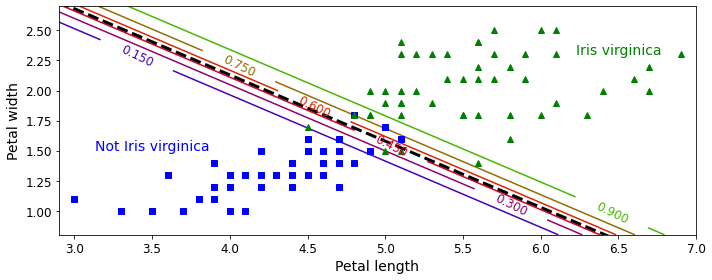

### Softmax Regression
Softmax Regression supports generalizing to multiple class predictions (i.e. not binary). The softmax score for each class k is defined:

$$ s_k(\textbf{x}) = \theta_k^T \cdot \textbf{x} $$

Then the softmax scores are put through the softmax function which converts them to probabilities of each class:

$$ \hat{p}_k = \frac{\text{exp} (s_k(\textbf{x}))}{\sum_{j=1}^K \text{exp} (s_j(\textbf{x}))} $$

The predicted class is the one with the highest score:

$$ \hat{y} = \underset{k}{\text{argmax}} \ s_k(\textbf{x}) $$

It's multiclass not multioutput. You couldn't use it to predict multiple people in one picture...

#### Cross Entropy
The cost function used for softmax regression is typically the cross entropy cost function defined as:

$$ J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y_k^{(i)} \log(\hat{p}_k^{(i)}) $$

In [66]:
# Using softmax on iris

X = iris["data"][:, (2, 3)]
y = iris["target"]
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

(0.0, 7.0, 0.0, 3.5)

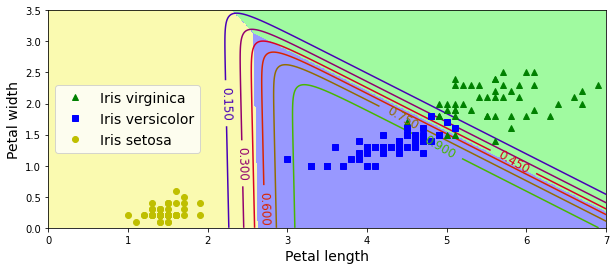

In [68]:
x0, x1 = np.meshgrid(
    np.linspace(0, 8, 500).reshape(-1, 1),
    np.linspace(0, 3.5, 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])